In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vision Workshop - Environment Setup

## Overview

[Vision Workshop](https://github.com/mblanc/vision-workshop) is a series of labs on how to build an image classification system on Google Cloud. Throughout the Vision Workshop labs, you will learn how to read image data stored in data lake, perform exploratory data analysis (EDA), train a model, register your model in a model registry, evaluate your model, deploy your model to an endpoint, do real-time inference on your model.

### Objective

Before you run this notebook, make sure that you have completed the steps in [README](README.md).

In this notebook, you will setup your environment for Fraudfinder to be used in subsequent labs.

This lab uses the following Google Cloud services and resources:

- [Vertex AI](https://cloud.google.com/vertex-ai/)
- [Google Cloud Storage](https://cloud.google.com/storage)

Steps performed in this notebook:

- Setup your environment.
- Load image data into Cloud Storage.
- Read data from Cloud Storage.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing)
to generate a cost estimate based on your projected usage.

### Install additional packages

Install the following packages required to execute this notebook.

In [ ]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

!pip install --upgrade --no-warn-conflicts '{USER_FLAG}' -q \
    google-cloud-pubsub==2.13.6 \
    google-api-core==2.8.2 \
    google-apitools==0.5.32 \
    plotly==5.10.0 \
    itables==1.2.0 \
    apache_beam==2.40.0 \
    plotly==5.10.0 \
    google-cloud-pipeline-components \
    kfp

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Setup your environment

Run the next cells to import libraries used in this notebook and configure some options.

Run the next cell to set your project ID and some of the other constants used in the lab.  

In [2]:
import random
import string

# Generate unique ID to help w/ unique naming of certain pieces
ID = "".join(random.choices(string.ascii_lowercase + string.digits, k=5))

GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
BUCKET_NAME = f"{PROJECT_ID}-vision-workshop"
REGION = "europe-west4"

### Create a Google Cloud Storage bucket and save the config data.

Next, we will create a Google Cloud Storage bucket and will save the config data in this bucket. After the cell operation finishes, you can navigate to [Google Cloud Storage](https://console.cloud.google.com/storage/) to see the GCS bucket. 

In [9]:
config = f"""
BUCKET_NAME          = \"{BUCKET_NAME}\"
PROJECT              = \"{PROJECT_ID}\"
REGION               = \"{REGION}\"
ID                   = \"{ID}\"
MODEL_NAME           = \"vision_workshop_model\"
ENDPOINT_NAME        = \"vision_workshop_endpoint\"
"""

!gsutil mb -l {REGION} gs://{BUCKET_NAME}

!echo '{config}' | gsutil cp - gs://{BUCKET_NAME}/config/notebook_env.py

Creating gs://svc-demo-vertex-vision-workshop/...
Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


### Copy the data into Google Cloud Storage

Now we will copy the data and ingest it into Google Cloud Storage.

In [4]:
!gsutil -m cp gs://cloud-samples-data/ai-platform/flowers/flowers_200_folders.zip .


Copying gs://cloud-samples-data/ai-platform/flowers/flowers_200_folders.zip...
- [1/1 files][ 11.4 MiB/ 11.4 MiB] 100% Done                                    
Operation completed over 1 objects/11.4 MiB.                                     


In [6]:
!mkdir flowers

In [8]:
!unzip flowers_200_folders.zip -d flowers

Archive:  flowers_200_folders.zip
   creating: flowers/daisy/
  inflating: flowers/daisy/16527403771_2391f137c4_n.jpg  
  inflating: flowers/daisy/2365428551_39f83f10bf_n.jpg  
  inflating: flowers/daisy/15853110333_229c439e7f.jpg  
  inflating: flowers/daisy/2556503265_63ae6b9e0e_m.jpg  
  inflating: flowers/daisy/510844526_858b8fe4db.jpg  
  inflating: flowers/daisy/525271784_013ddccd1b_m.jpg  
  inflating: flowers/daisy/2561371688_c80a4fe957_n.jpg  
  inflating: flowers/daisy/14613443462_d4ed356201.jpg  
  inflating: flowers/daisy/1355787476_32e9f2a30b.jpg  
  inflating: flowers/daisy/305160642_53cde0f44f.jpg  
  inflating: flowers/daisy/9321854387_5f77c926cb_n.jpg  
  inflating: flowers/daisy/12193032636_b50ae7db35_n.jpg  
  inflating: flowers/daisy/4281102584_c548a69b81_m.jpg  
  inflating: flowers/daisy/3975010332_3209f9f447_m.jpg  
  inflating: flowers/daisy/5110109540_beed4ed162_m.jpg  
  inflating: flowers/daisy/2045022175_ad087f5f60_n.jpg  
  inflating: flowers/daisy/15760153

In [11]:
!gsutil -m cp -r flowers gs://{BUCKET_NAME}/

Copying file://flowers/tulips/13910737760_c71c8b6ff2.jpg [Content-Type=image/jpeg]...
Copying file://flowers/tulips/14262354955_cc2ab3b112_m.jpg [Content-Type=image/jpeg]...
Copying file://flowers/tulips/4574785121_5d8ec4626e.jpg [Content-Type=image/jpeg]...
Copying file://flowers/tulips/13561908485_7e4f8d508b.jpg [Content-Type=image/jpeg]...
Copying file://flowers/tulips/5700394524_dc6f8fa9cd_n.jpg [Content-Type=image/jpeg]...
Copying file://flowers/tulips/7166567320_0a2beb6d42.jpg [Content-Type=image/jpeg]...
Copying file://flowers/tulips/3510799169_0ed6ae9669_n.jpg [Content-Type=image/jpeg]...
Copying file://flowers/tulips/7145978709_2d1596f462.jpg [Content-Type=image/jpeg]...
Copying file://flowers/tulips/16930121391_a4092ecf00_n.jpg [Content-Type=image/jpeg]...
Copying file://flowers/tulips/5700466891_2bcb17fa68_n.jpg [Content-Type=image/jpeg]...
Copying file://flowers/tulips/15275504998_ca9eb82998.jpg [Content-Type=image/jpeg]...
Copying file://flowers/tulips/3637371174_a8dfcc1b3

In [13]:
BUCKET_NAME

'svc-demo-vertex-vision-workshop'

### Check data in Google Cloud Storage

After ingesting our data into GCS, it's time to visualize some images to inspect the data.

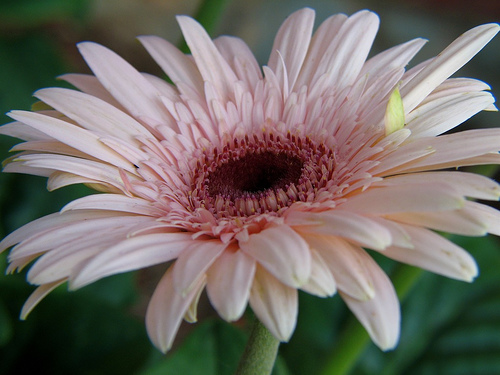

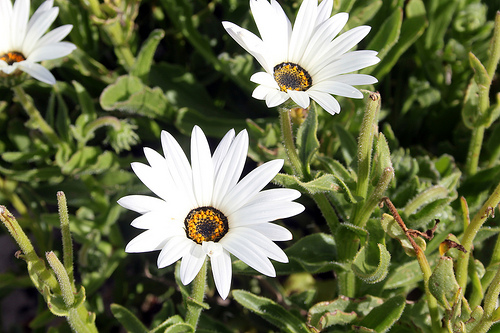

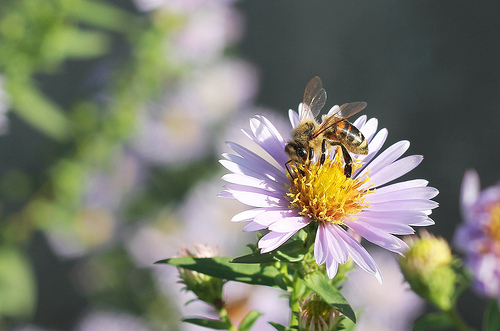

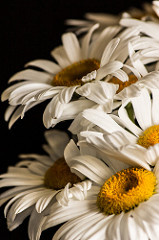

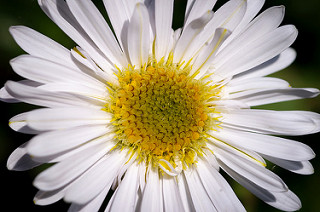

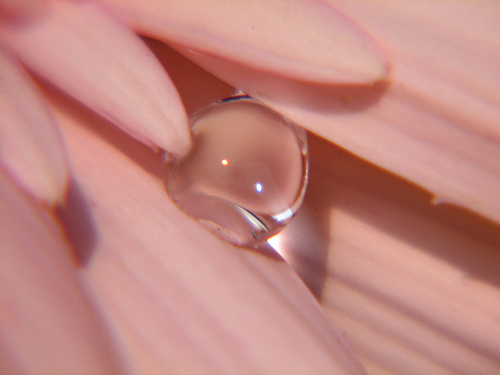

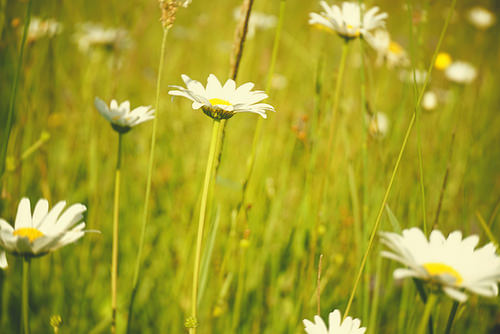

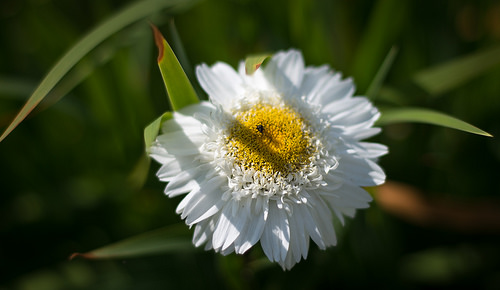

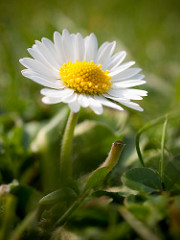

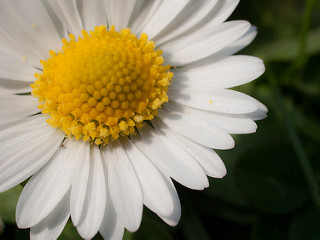

In [38]:
import itertools
from google.cloud import storage
from IPython.display import Image, display

client = storage.Client() 

# Implicit environment set up
# with explicit set up:
# client = storage.Client.from_service_account_json('key-file-location')

blobs = client.list_blobs(BUCKET_NAME, prefix='flowers/')

images = [blob.download_as_bytes() for blob in itertools.islice(blobs, 10)]


for image in images:
    display(Image(image))

### END

Now you can go to the next notebook `01_exploratory_data_analysis.ipynb`